In [108]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/formula-1-world-championship-1950-2020/races.csv
/kaggle/input/formula-1-world-championship-1950-2020/constructor_results.csv
/kaggle/input/formula-1-world-championship-1950-2020/drivers.csv
/kaggle/input/formula-1-world-championship-1950-2020/constructors.csv
/kaggle/input/formula-1-world-championship-1950-2020/lap_times.csv
/kaggle/input/formula-1-world-championship-1950-2020/status.csv
/kaggle/input/formula-1-world-championship-1950-2020/driver_standings.csv
/kaggle/input/formula-1-world-championship-1950-2020/seasons.csv
/kaggle/input/formula-1-world-championship-1950-2020/pit_stops.csv
/kaggle/input/formula-1-world-championship-1950-2020/sprint_results.csv
/kaggle/input/formula-1-world-championship-1950-2020/constructor_standings.csv
/kaggle/input/formula-1-world-championship-1950-2020/results.csv
/kaggle/input/formula-1-world-championship-1950-2020/circuits.csv
/kaggle/input/formula-1-world-championship-1950-2020/qualifying.csv


In [109]:
import pandas as pd
import zipfile
import os
import matplotlib.pyplot as plt

In [110]:
# Define the paths to the uploaded files
file_paths = {
    "drivers": "/kaggle/input/formula-1-world-championship-1950-2020/drivers.csv",
    "lap_times": "/kaggle/input/formula-1-world-championship-1950-2020/lap_times.csv",
    "pit_stops": "/kaggle/input/formula-1-world-championship-1950-2020/pit_stops.csv",
    "qualifying": "/kaggle/input/formula-1-world-championship-1950-2020/qualifying.csv",
    "races": "/kaggle/input/formula-1-world-championship-1950-2020/races.csv",
    "results": "/kaggle/input/formula-1-world-championship-1950-2020/results.csv",
    "seasons": "/kaggle/input/formula-1-world-championship-1950-2020/seasons.csv",
    "sprint_results": "/kaggle/input/formula-1-world-championship-1950-2020/sprint_results.csv",
    "pit_stops": "/kaggle/input/formula-1-world-championship-1950-2020/pit_stops.csv"
}

# Load each dataset into a dictionary of DataFrames
dataframes = {}
for name, path in file_paths.items():
    try:
        dataframes[name] = pd.read_csv(path)
    except Exception as e:
        dataframes[name] = None
        print(f"Error loading {name}: {e}")

# Display basic info about each dataset
info_summary = {name: df.info() if df is not None else f"{name} not loaded" for name, df in dataframes.items()}
info_summary

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 859 entries, 0 to 858
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   driverId     859 non-null    int64 
 1   driverRef    859 non-null    object
 2   number       859 non-null    object
 3   code         859 non-null    object
 4   forename     859 non-null    object
 5   surname      859 non-null    object
 6   dob          859 non-null    object
 7   nationality  859 non-null    object
 8   url          859 non-null    object
dtypes: int64(1), object(8)
memory usage: 60.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575029 entries, 0 to 575028
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   raceId        575029 non-null  int64 
 1   driverId      575029 non-null  int64 
 2   lap           575029 non-null  int64 
 3   position      575029 non-null  int64 
 4   time          575029 

{'drivers': None,
 'lap_times': None,
 'pit_stops': None,
 'qualifying': None,
 'races': None,
 'results': None,
 'seasons': None,
 'sprint_results': None}

In [144]:
# Load necessary datasets into DataFrames
drivers_df = dataframes['drivers']
lap_times_df = dataframes['lap_times']
results_df = dataframes['results']
races_df = dataframes['races']
races_df = races_df[races_df['year'] >= 2001]
pit_stops = dataframes["pit_stops"]
qualifying_df = dataframes['qualifying']

# Merge lap_times with results on driverId and raceId
lap_results_df = pd.merge(lap_times_df, results_df, on=["raceId", "driverId"])

# Merge with drivers to get driver names
driver_performance_df = pd.merge(lap_results_df, drivers_df, on="driverId")

# Merge with races to get season info
driver_performance_df = pd.merge(driver_performance_df, races_df[['raceId', 'year']], on="raceId")
driver_performance_df.rename(columns={'milliseconds_x': 'lap_times_milliseconds', 'milliseconds_y': 'results_milliseconds'}, inplace=True)
driver_performance_df.columns

Index(['raceId', 'driverId', 'lap', 'position_x', 'time_x',
       'lap_times_milliseconds', 'resultId', 'constructorId', 'number_x',
       'grid', 'position_y', 'positionText', 'positionOrder', 'points', 'laps',
       'time_y', 'results_milliseconds', 'fastestLap', 'rank',
       'fastestLapTime', 'fastestLapSpeed', 'statusId', 'driverRef',
       'number_y', 'code', 'forename', 'surname', 'dob', 'nationality', 'url',
       'year'],
      dtype='object')

In [142]:
# Select and clean necessary columns for analysis
driver_performance_df = driver_performance_df[["driverId", "code", "forename", "surname", "year", "raceId", "lap", "lap_times_milliseconds", "positionOrder"]]

# Convert milliseconds to seconds for readability
driver_performance_df["lap_time_sec"] = driver_performance_df["lap_times_milliseconds"] / 1000

# Display a sample of the combined dataset
driver_performance_df.sample(10)

,driverId,code,forename,surname,year,raceId,lap,lap_times_milliseconds,positionOrder,lap_time_sec
391237,66,\N,Allan,McNish,2002,131,5,80968,17,80.968
294327,846,NOR,Lando,Norris,2021,1061,49,92868,4,92.868
376454,4,ALO,Fernando,Alonso,2024,1126,12,95193,9,95.193
105145,832,SAI,Carlos,Sainz,2015,939,20,114814,9,114.814
354837,815,PER,Sergio,Pérez,2023,1105,56,77484,4,77.484
336558,3,ROS,Nico,Rosberg,2007,43,42,77550,9,77.550
58842,818,VER,Jean-Éric,Vergne,2013,887,28,100862,22,100.862
223169,830,VER,Max,Verstappen,2018,993,3,133094,3,133.094
95664,1,HAM,Lewis,Hamilton,2015,930,3,92342,2,92.342
77405,820,CHI,Max,Chilton,2014,904,59,92881,19,92.881


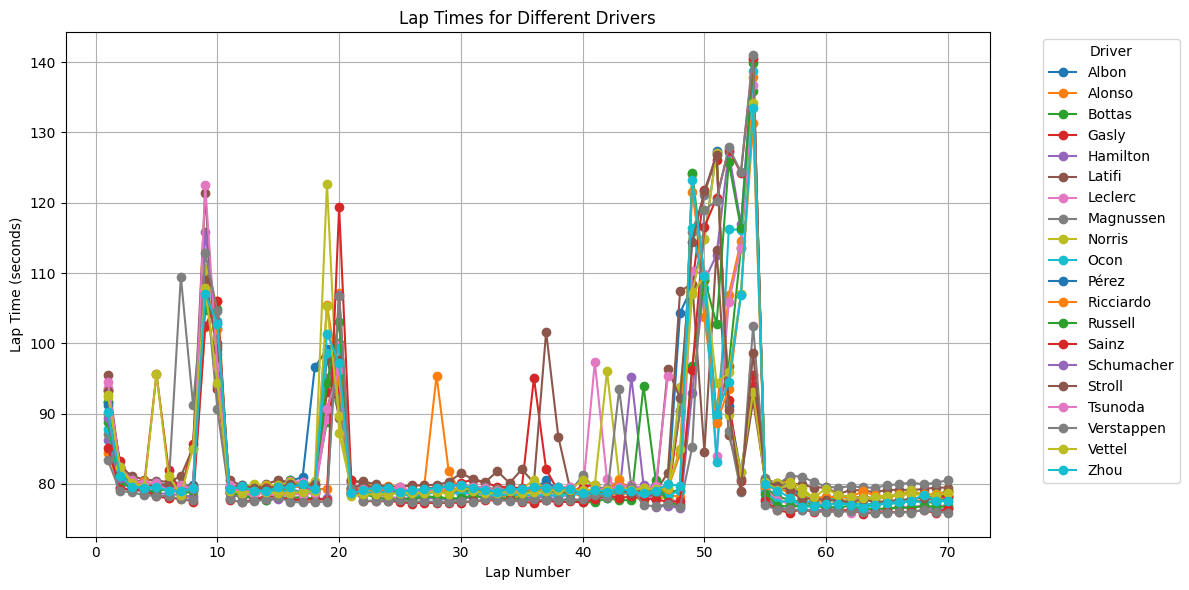

In [114]:
race_id = 1082
driver_performance_df_1082 = driver_performance_df[driver_performance_df["raceId"] == race_id]

# Plot lap times for each driver
plt.figure(figsize=(12, 6))

for driver, group in driver_performance_df_1082.groupby("surname"):
    plt.plot(group["lap"], group["lap_time_sec"], label=driver, marker="o",linestyle='-')

plt.xlabel("Lap Number")
plt.ylabel("Lap Time (seconds)")
plt.title("Lap Times for Different Drivers")
plt.legend(title="Driver", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)

plt.show()

In [ ]:
# Race Analysis 

# Lando Performance At Monaco Over the Years

In [121]:
monaco = races_df[races_df["circuitId"]==6]
monaco_races = list(monaco["raceId"])
monaco_races

[6,
 23,
 40,
 59,
 76,
 95,
 114,
 130,
 147,
 342,
 846,
 865,
 885,
 905,
 931,
 953,
 974,
 994,
 1015,
 1056,
 1080,
 1104,
 1128]

In [147]:
# Initialize an empty DataFrame to store the results
monaco_performance_df = pd.DataFrame()
monaco_pitstops_df = pd.DataFrame()
monaco_qualifying_df = pd.DataFrame()

# Loop through each race in monaco_races and append the filtered data
for i in monaco_races:
    monaco_pitstops = pit_stops[pit_stops['raceId'] == i]
    monaco_pitstops_df = pd.concat([monaco_pitstops_df, monaco_pitstops], ignore_index=True)
    monaco_qualifying = qualifying_df[qualifying_df['raceId'] == i]
    monaco_qualifying_df = pd.concat([monaco_qualifying_df, monaco_qualifying], ignore_index=True)
    monaco_performance = driver_performance_df[driver_performance_df['raceId'] == i]
    monaco_performance_df = pd.concat([monaco_performance_df, monaco_performance], ignore_index=True)

In [150]:
monaco_pitstops_df.shape

(411, 8)

In [153]:
lando_monaco = monaco_performance_df[monaco_performance_df["code"]=="NOR"]
lando_pitstop = monaco_pitstops_df[monaco_pitstops_df["driverId"]==846]
lando_monaco.head()

,raceId,driverId,lap,position_x,time_x,lap_times_milliseconds,resultId,constructorId,number_x,grid,...,statusId,driverRef,number_y,code,forename,surname,dob,nationality,url,year
25568,1015,846,1,13,1:33.112,93112,24316,1,4,12,...,1,norris,4,NOR,Lando,Norris,1999-11-13,British,http://en.wikipedia.org/wiki/Lando_Norris,2019
25569,1015,846,2,14,1:21.330,81330,24316,1,4,12,...,1,norris,4,NOR,Lando,Norris,1999-11-13,British,http://en.wikipedia.org/wiki/Lando_Norris,2019
25570,1015,846,3,14,1:19.890,79890,24316,1,4,12,...,1,norris,4,NOR,Lando,Norris,1999-11-13,British,http://en.wikipedia.org/wiki/Lando_Norris,2019
25571,1015,846,4,14,1:19.536,79536,24316,1,4,12,...,1,norris,4,NOR,Lando,Norris,1999-11-13,British,http://en.wikipedia.org/wiki/Lando_Norris,2019
25572,1015,846,5,14,1:19.840,79840,24316,1,4,12,...,1,norris,4,NOR,Lando,Norris,1999-11-13,British,http://en.wikipedia.org/wiki/Lando_Norris,2019


In [152]:
lando_pitstop.shape

(9, 8)

In [155]:
lando_monaco_quali = monaco_qualifying_df[monaco_qualifying_df["driverId"]==846]
lando_monaco_quali 

,qualifyId,raceId,driverId,constructorId,number,position,q1,q2,q3
350,8069,1015,846,1,4,12,1:11.845,1:11.724,\N
363,8819,1056,846,1,4,5,1:11.321,1:11.031,1:10.620
382,9317,1080,846,1,4,5,1:12.927,1:12.266,1:11.849
407,9742,1104,846,1,4,10,1:12.877,1:12.377,1:12.254
421,10215,1128,846,1,4,4,1:11.760,1:10.732,1:10.542


<ipython-input-160-0ab428e6ffae>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lando_monaco_quali['q1_sec'] = lando_monaco_quali['q1'].apply(time_to_seconds)
<ipython-input-160-0ab428e6ffae>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lando_monaco_quali['q2_sec'] = lando_monaco_quali['q2'].apply(time_to_seconds)
<ipython-input-160-0ab428e6ffae>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

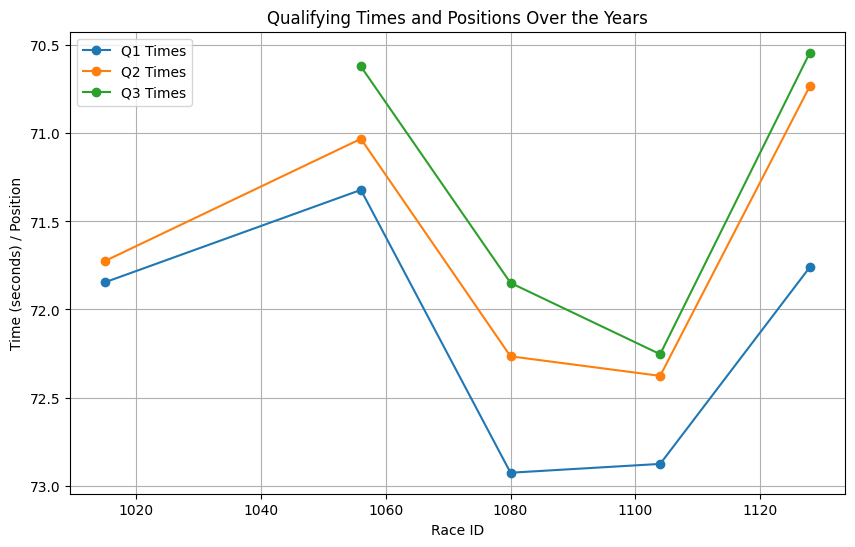

In [160]:
# Convert qualifying times to seconds for plotting
def time_to_seconds(t):
    if t is None or t == '\\N':
        return None
    minutes, seconds = t.split(':')
    return int(minutes) * 60 + float(seconds)

lando_monaco_quali['q1_sec'] = lando_monaco_quali['q1'].apply(time_to_seconds)
lando_monaco_quali['q2_sec'] = lando_monaco_quali['q2'].apply(time_to_seconds)
lando_monaco_quali['q3_sec'] = lando_monaco_quali['q3'].apply(time_to_seconds)

# Plot qualifying positions and times over the races
plt.figure(figsize=(10, 6))

# Plot Q1, Q2, and Q3 times
plt.plot(lando_monaco_quali['raceId'], lando_monaco_quali['q1_sec'], marker='o', label='Q1 Times')
plt.plot(lando_monaco_quali['raceId'], lando_monaco_quali['q2_sec'], marker='o', label='Q2 Times')
plt.plot(lando_monaco_quali['raceId'], lando_monaco_quali['q3_sec'], marker='o', label='Q3 Times')

# Customize plot
plt.xlabel('Race ID')
plt.ylabel('Time (seconds) / Position')
plt.title('Qualifying Times and Positions Over the Years')
plt.legend()
plt.grid(True)
plt.gca().invert_yaxis()  # Invert y-axis for position (lower numbers are better)

plt.show()

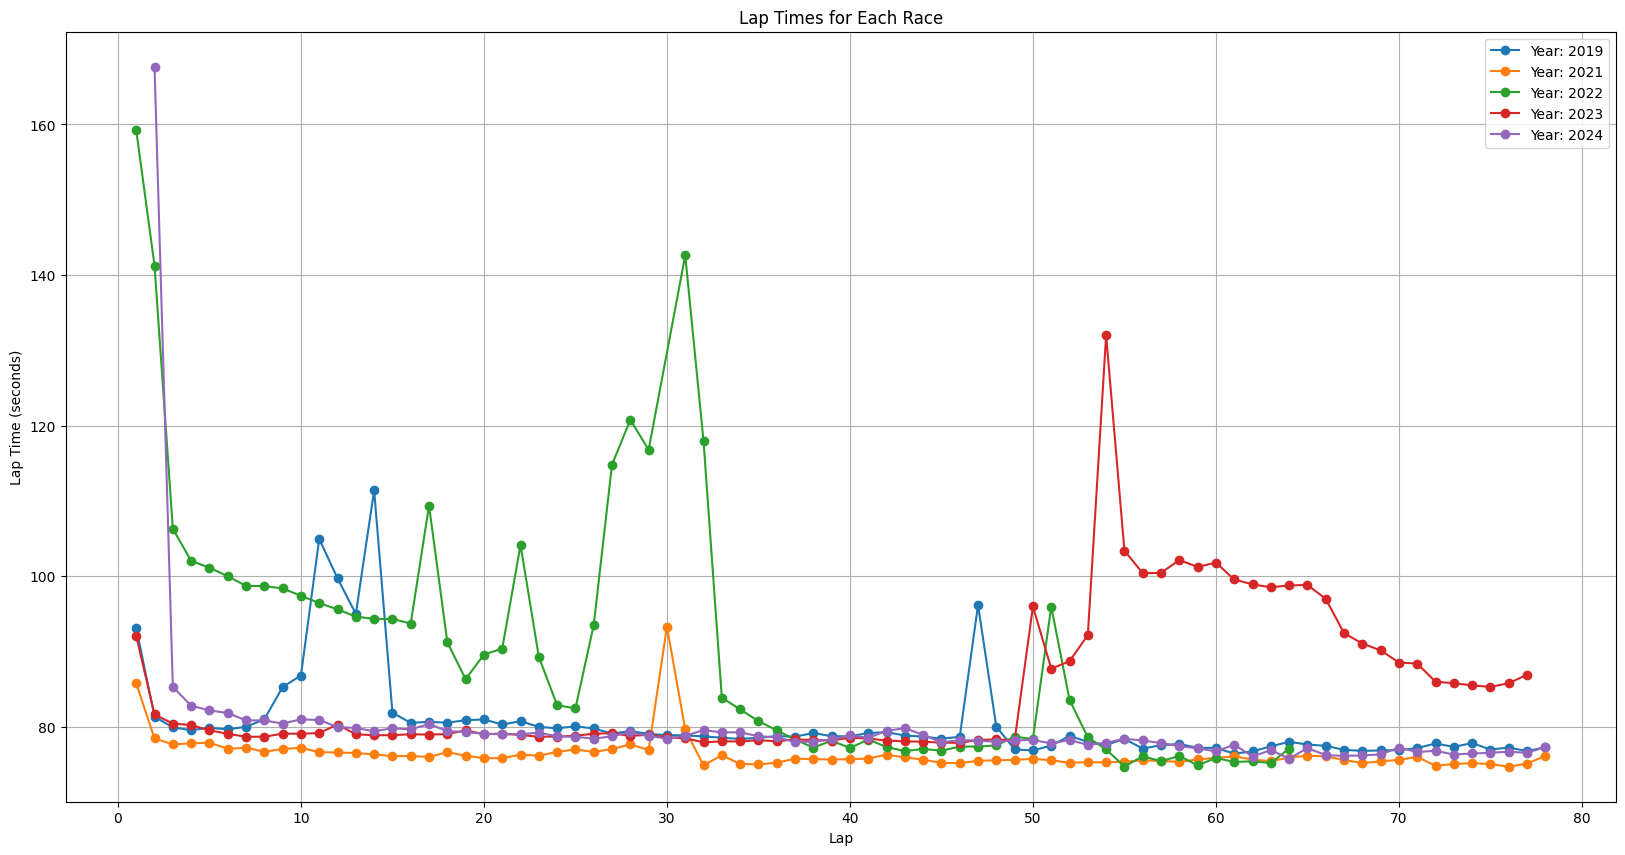

In [128]:
threshold = 500
# Filter out anomalies
lando_monaco = lando_monaco[lando_monaco['lap_time_sec'] <= threshold]

# Plot lap times for each race
plt.figure(figsize=(20, 10))

# Group data by raceId and plot lap times
for race_id, group in lando_monaco.groupby('year'):
    plt.plot(group['lap'], group['lap_time_sec'], marker='o', label=f'Year: {race_id}')

# Plot customization
plt.xlabel('Lap')
plt.ylabel('Lap Time (seconds)')
plt.title('Lap Times for Each Race')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

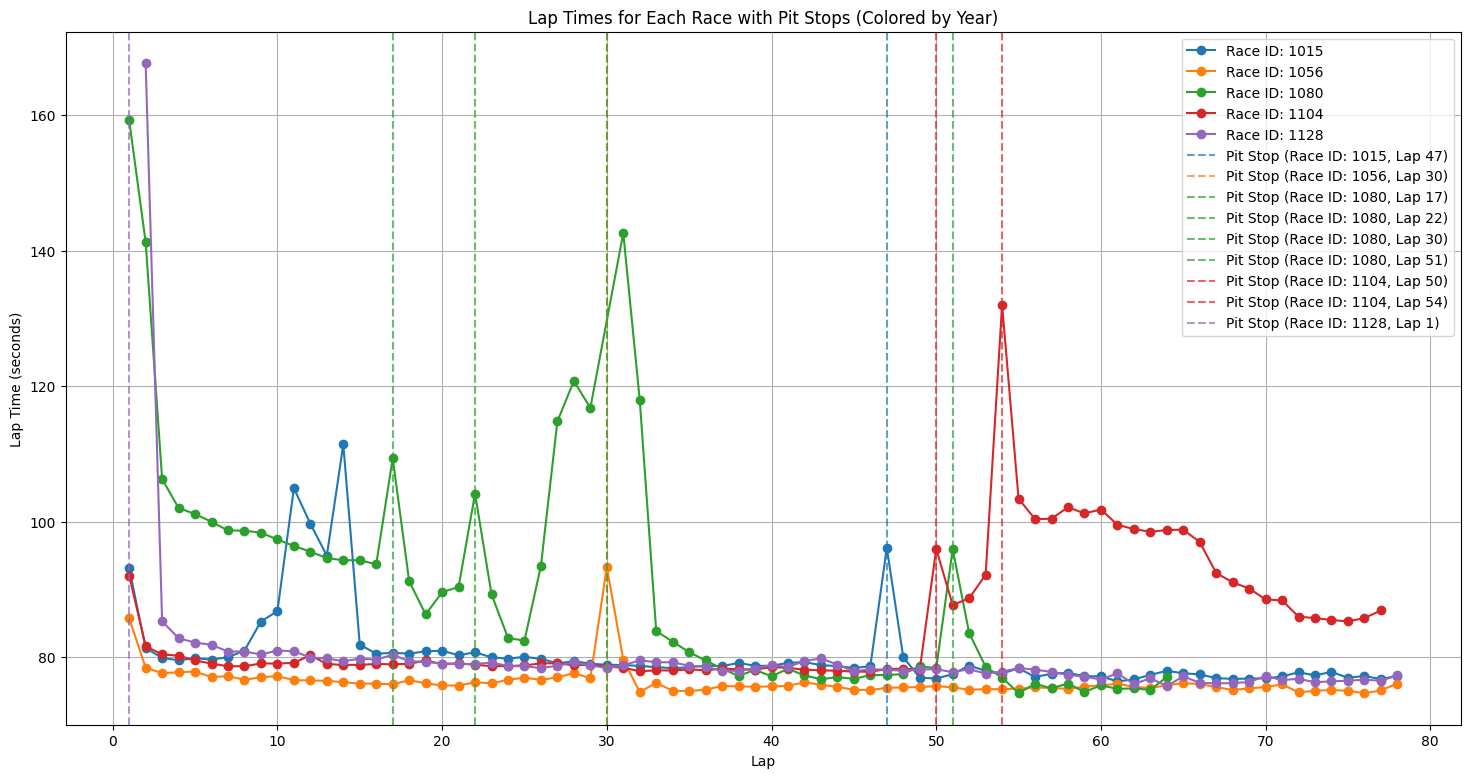

In [138]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Sample DataFrames (assuming these are already created: lap_df and pitstop_df)

# Generate unique colors for each pit stop year
unique_race_ids = lando_pitstop['raceId'].unique()
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot lap times for each race
plt.figure(figsize=(18, 9))

# Plot lap times
for race_id, group in lando_monaco.groupby('raceId'):
    plt.plot(group['lap'], group['lap_time_sec'], marker='o', label=f'Race ID: {race_id}')

# Plot pit stops with different colors for each race
for i, (race_id, group) in enumerate(lando_pitstop.groupby('raceId')):
    color = colors[i % len(colors)]
    for _, row in group.iterrows():
        plt.axvline(x=row['lap'], color=color, linestyle='--', alpha=0.7, label=f'Pit Stop (Race ID: {race_id}, Lap {row["lap"]})')

# Customization
plt.xlabel('Lap')
plt.ylabel('Lap Time (seconds)')
plt.title('Lap Times for Each Race with Pit Stops (Colored by Year)')
plt.legend()
plt.grid(True)

# Show plot
plt.show()